# Fit to a curve in a logarithmic plane

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import pandas as pd

Consider the following set of points:

<img src="./lux2016.png" width="400"/>

In [3]:
df=pd.read_csv('lux2016.csv')

In [4]:
df.columns

Index([u'M', u'sigma'], dtype='object')

In [5]:
x=df.columns[0]
y=df.columns[1]
df[y]=1E36*df[y]

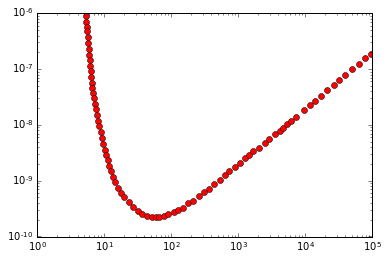

In [6]:
plt.loglog(df[x],df[y],'ro')

In [7]:
from curvefit import *

In [8]:
lux=curvefit(df[x].values,df[y].values)

poly1d([ -0.07273834,   1.17657839,  -7.39032516,  22.54681114,
       -32.54672819,   7.94825022])

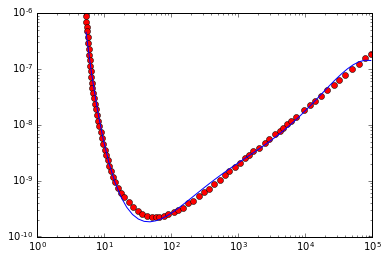

In [24]:
lux.add_fit(5)

poly1d([  2.97155253e-03,  -1.04859712e-01,   1.65957619e+00,
        -1.55554775e+01,   9.60373530e+01,  -4.10854571e+02,
         1.24717840e+03,  -2.70344316e+03,   4.14943557e+03,
        -4.39731524e+03,   3.05940617e+03,  -1.26260929e+03,
         2.27734207e+02])

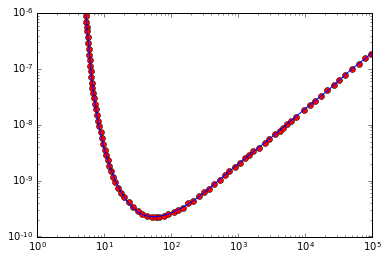

In [25]:
lux.add_fit(12)

In [39]:
lux.

2.6422688481222753e-10

## Save and recovery

In [26]:
lux.to_csv('lux2016_12.csv')

In [27]:
lux_new=curvefit()

In [28]:
lux_new.read_csv('lux2016_12.csv')

In [29]:
xlog=np.logspace( np.log10( 5 ),np.log10( 1E5 ) )

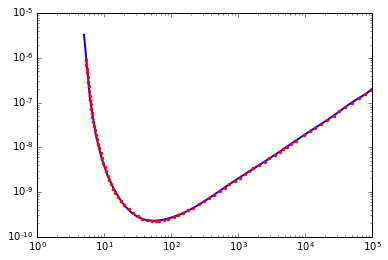

In [32]:
plt.loglog( xlog,lux_new(xlog),lw=2)                 
plt.loglog(df[x],df[y],'r.')

In [33]:
lux_new(100)

2.6422713558051399e-10

In [36]:
print lux_new.poly1d

          12          11        10         9         8         7
0.002972 x  - 0.1049 x  + 1.66 x  - 15.56 x + 96.04 x - 410.9 x
         6        5        4        3        2
 + 1247 x - 2703 x + 4149 x - 4397 x + 3059 x - 1263 x + 227.7


## See implementation in multi-curves:
[multicurves](./multicurvefit.ipynb)